# Машинное обучение, ФКН ВШЭ

## Практическое задание 3

### Общая информация
Дата выдачи: 27.11.2017  

Мягкий дедлайн: 23:59MSK 10.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.12.2017  

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+151@gmail.com для студентов группы БПМИ-151)

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [144]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [3]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.561908796475414

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.55360859564421

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [145]:
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [146]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок


__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [82]:

def trees(sample_size, samples_num, title, depth):
    plt.figure(figsize=(20, 7))
    plt.title(title)
    estimation = np.array([])
    for i in range(samples_num):
        #data
        X = np.random.exponential(size=sample_size)
        noize = np.random.uniform(low=-1, high=1.1, size=sample_size)
        y = (f(X) + noize).reshape(-1, 1)
        X = X.reshape(-1, 1)
        linspace = np.linspace(0, 7, 1000)  # точки для построения графиков
        linspace = linspace.reshape(-1, 1)
        #model
        regr = DecisionTreeRegressor(max_depth = depth)
        regr.fit(X, y)
        prediction = regr.predict(linspace.reshape(-1, 1))
        
        #plot
        if i == 0:
            estimation = prediction.reshape(prediction.size, 1)
            plt.plot(linspace, prediction, label='prediction', color='gray', alpha=0.5)
        else:
            estimation = np.concatenate((estimation, prediction.reshape(prediction.size, 1)), axis=1)
            plt.plot(linspace, prediction, color='gray', alpha=0.5)
    estimation = estimation.mean(axis=1)
    
    if samples_num != 1:
        plt.plot(linspace, estimation, label='estimated f(x)', color='black')    
    plt.plot(linspace, f(linspace), label='f(x)', color='red')
    plt.xlabel('X')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid()
    plt.show()

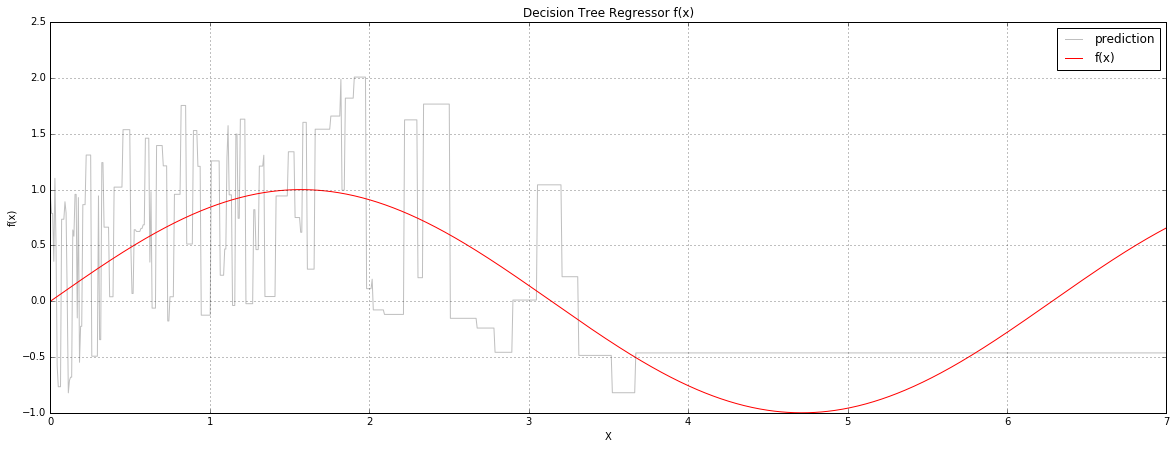

In [118]:
trees(sample_size, 1, 'Decision Tree Regressor f(x)', None)

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

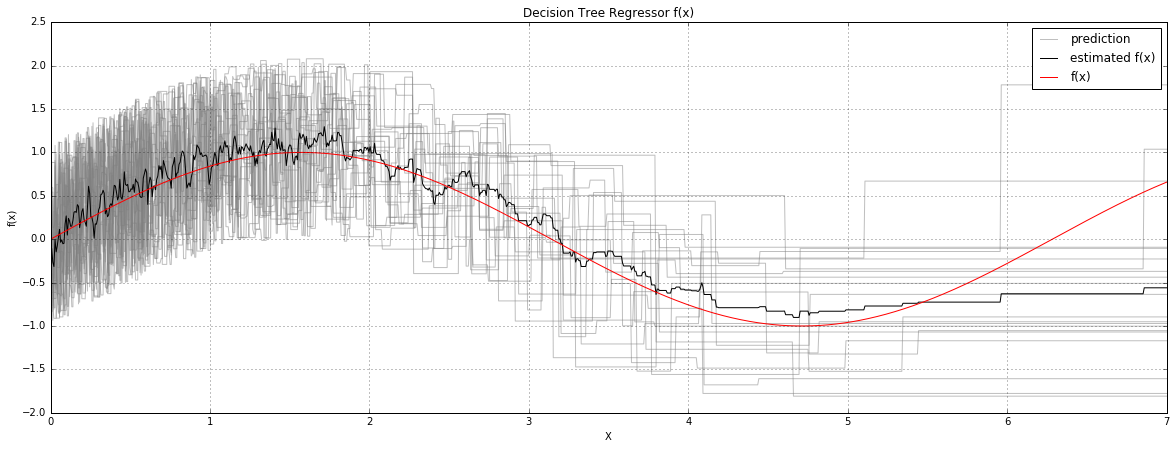

In [119]:
trees(sample_size, samples_num, 'Decision Tree Regressor f(x)', None)

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

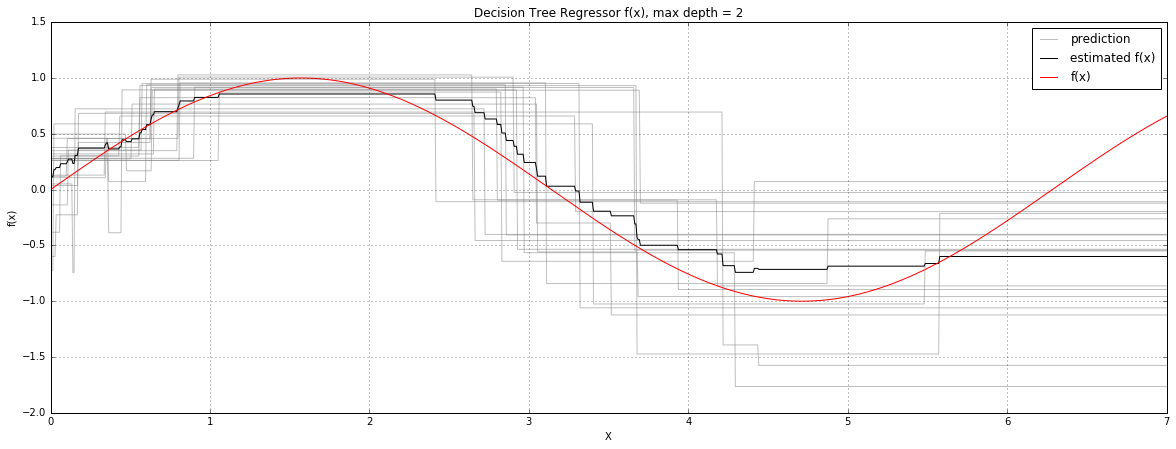

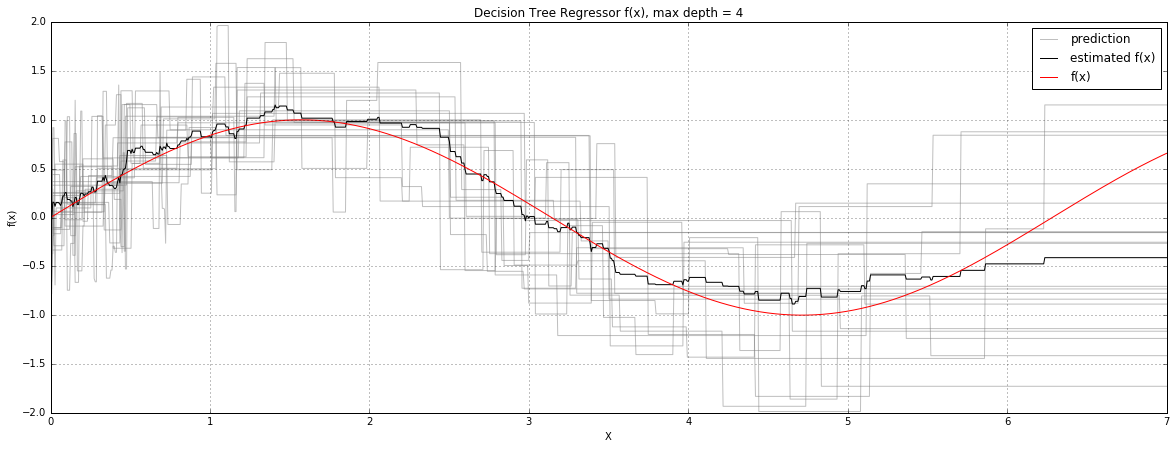

In [120]:
trees(sample_size, samples_num, 'Decision Tree Regressor f(x), max depth = 2', 2)
trees(sample_size, samples_num, 'Decision Tree Regressor f(x), max depth = 4', 4)

__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:**

Чем больше глубина, тем меньше смещение. Возможно, можно сказать, что на последнем графике смещение равно нулю, хотя разброс все же большой.

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функцию compute_bias_variance из модуля hw3code.py

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [147]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [148]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [149]:
df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [150]:
from importlib import reload
import hw3code

reload(hw3code)


<module 'hw3code' from '/home/darya/Documents/MO/homework-practice-03-KorepanovaDarya/hw3code.py'>

In [151]:
# по какой-то причине эта функция не зашла в контест
for i in range(len(regressors)):
    for j in range(len(generators)):
        bias, variance = hw3code.compute_bias_variance(regressors[i], lambda x: 5 * np.sin(10 * x), generators[j])
        df_bias.iloc[i, j] = bias
        df_variance.iloc[i, j] = variance

In [152]:
df_bias

normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression        12.1997          8.33001        11.4114       10.7287
DecisionTree           0.119612        0.0762571    0.000612631   0.000376056
RandomForest           0.146258         0.106691     0.00135368   0.000491478
GradientBoosting       0.122486        0.0799934      0.0095514   0.000927864

In [153]:
df_variance

normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression      0.0872577        0.0912643      0.0778038     0.0516679
DecisionTree           0.152334         0.261691       0.111735     0.0903884
RandomForest          0.0956868         0.166807      0.0673579     0.0492803
GradientBoosting       0.100909         0.200038      0.0659978     0.0410433

__7. (0.6 балла)__

Проанализируйте полученные таблицы. Ответьте на вопросы:
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?

* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 


* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

Ответ:

1) [LR, RF, DB, DT] Вообще, для каждого алгоритма есть отклонение в ранжировке для одного распределения, но вцелом, если брать по большинству, то так. Вообщем, согласуется, LR модель линейная (=простая), обладает низким разбросом. RF хорошо работает за счет усреднения. Остальные модели более гибкие (=сложные, имеют больше параметров), так что сильнее насраиваются на выбросы, переобущаются и т.д. Следовательно, разброс большой.

2) Нельзя. Мы восстанавливаем исходную зависимость по выборке, которая напрямую зависит от распределения из которого ее сгенерировали. Разные распределения имеют разные плотности, какие-то значения чаще получаются, какие-то реже. Вообщем смещение и разброс определяются еще и выборкой (там в формуле есть мат ожидания, которые разные для разных распределений). да и по результатам эксперимента видно, что нет.

3) Для равномерного на [-1,1] и нормального . Так происходит потому что они симметричные относительно нуля. Получаются равновероятно отрицательные и положительные значения и в общем сложно подобрать хороший порог для разбиения каждый раз когда для объекты и ответы очень разнятся.

**Ответ:**

__8. (бонус, 0.5 балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

In [117]:
def draw_bias_var(name, array, title):
    values_bias = [[] for i in range(len(regressors))]
    values_variance = [[] for i in range(len(regressors))]
    
    n_row = 2
    n_col = 4
    fig, ax = plt.subplots(nrows=n_row, ncols=n_col, figsize=(40, 20))

    num_j = 0
    num_i = 0
    for j in generators:
        for i in regressors:
            for param in array:
                tmp_b, tmp_v = hw3code.compute_bias_variance(i, lambda x: 5 * np.sin(10 * x), j, **{name:param})
                values_bias[num_i].append(tmp_b)
                values_variance[num_i].append(tmp_v)
            num_i += 1
        num_i = 0


        ax[0, num_j].set_title(df_bias.columns[num_j])
        ax[0, num_j].plot(array, values_bias[0], label='LinearRegression', color='blue')
        ax[0, num_j].plot(array, values_bias[1], label='DecisionTree', color='red')
        ax[0, num_j].plot(array, values_bias[2], label='RandomForest', color='green')
        ax[0, num_j].plot(array, values_bias[3], label='GradientBoosting', color='black')
        ax[0, num_j].set_xlabel(name)
        ax[0, num_j].set_ylabel('bias')
        ax[0, num_j].legend() 
        ax[0, num_j].grid()

        ax[1, num_j].plot(array, values_variance[0], label='LinearRegression', color='blue')
        ax[1, num_j].plot(array, values_variance[1], label='DecisionTree', color='red')
        ax[1, num_j].plot(array, values_variance[2], label='RandomForest', color='green')
        ax[1, num_j].plot(array, values_variance[3], label='GradientBoosting', color='black')
        ax[1, num_j].set_xlabel(name)
        ax[1, num_j].set_ylabel('variance')
        ax[1, num_j].legend()
        ax[1, num_j].grid()
        values_bias = [[] for k in range(len(regressors))]
        values_variance = [[] for k in range(len(regressors))]
        num_j += 1


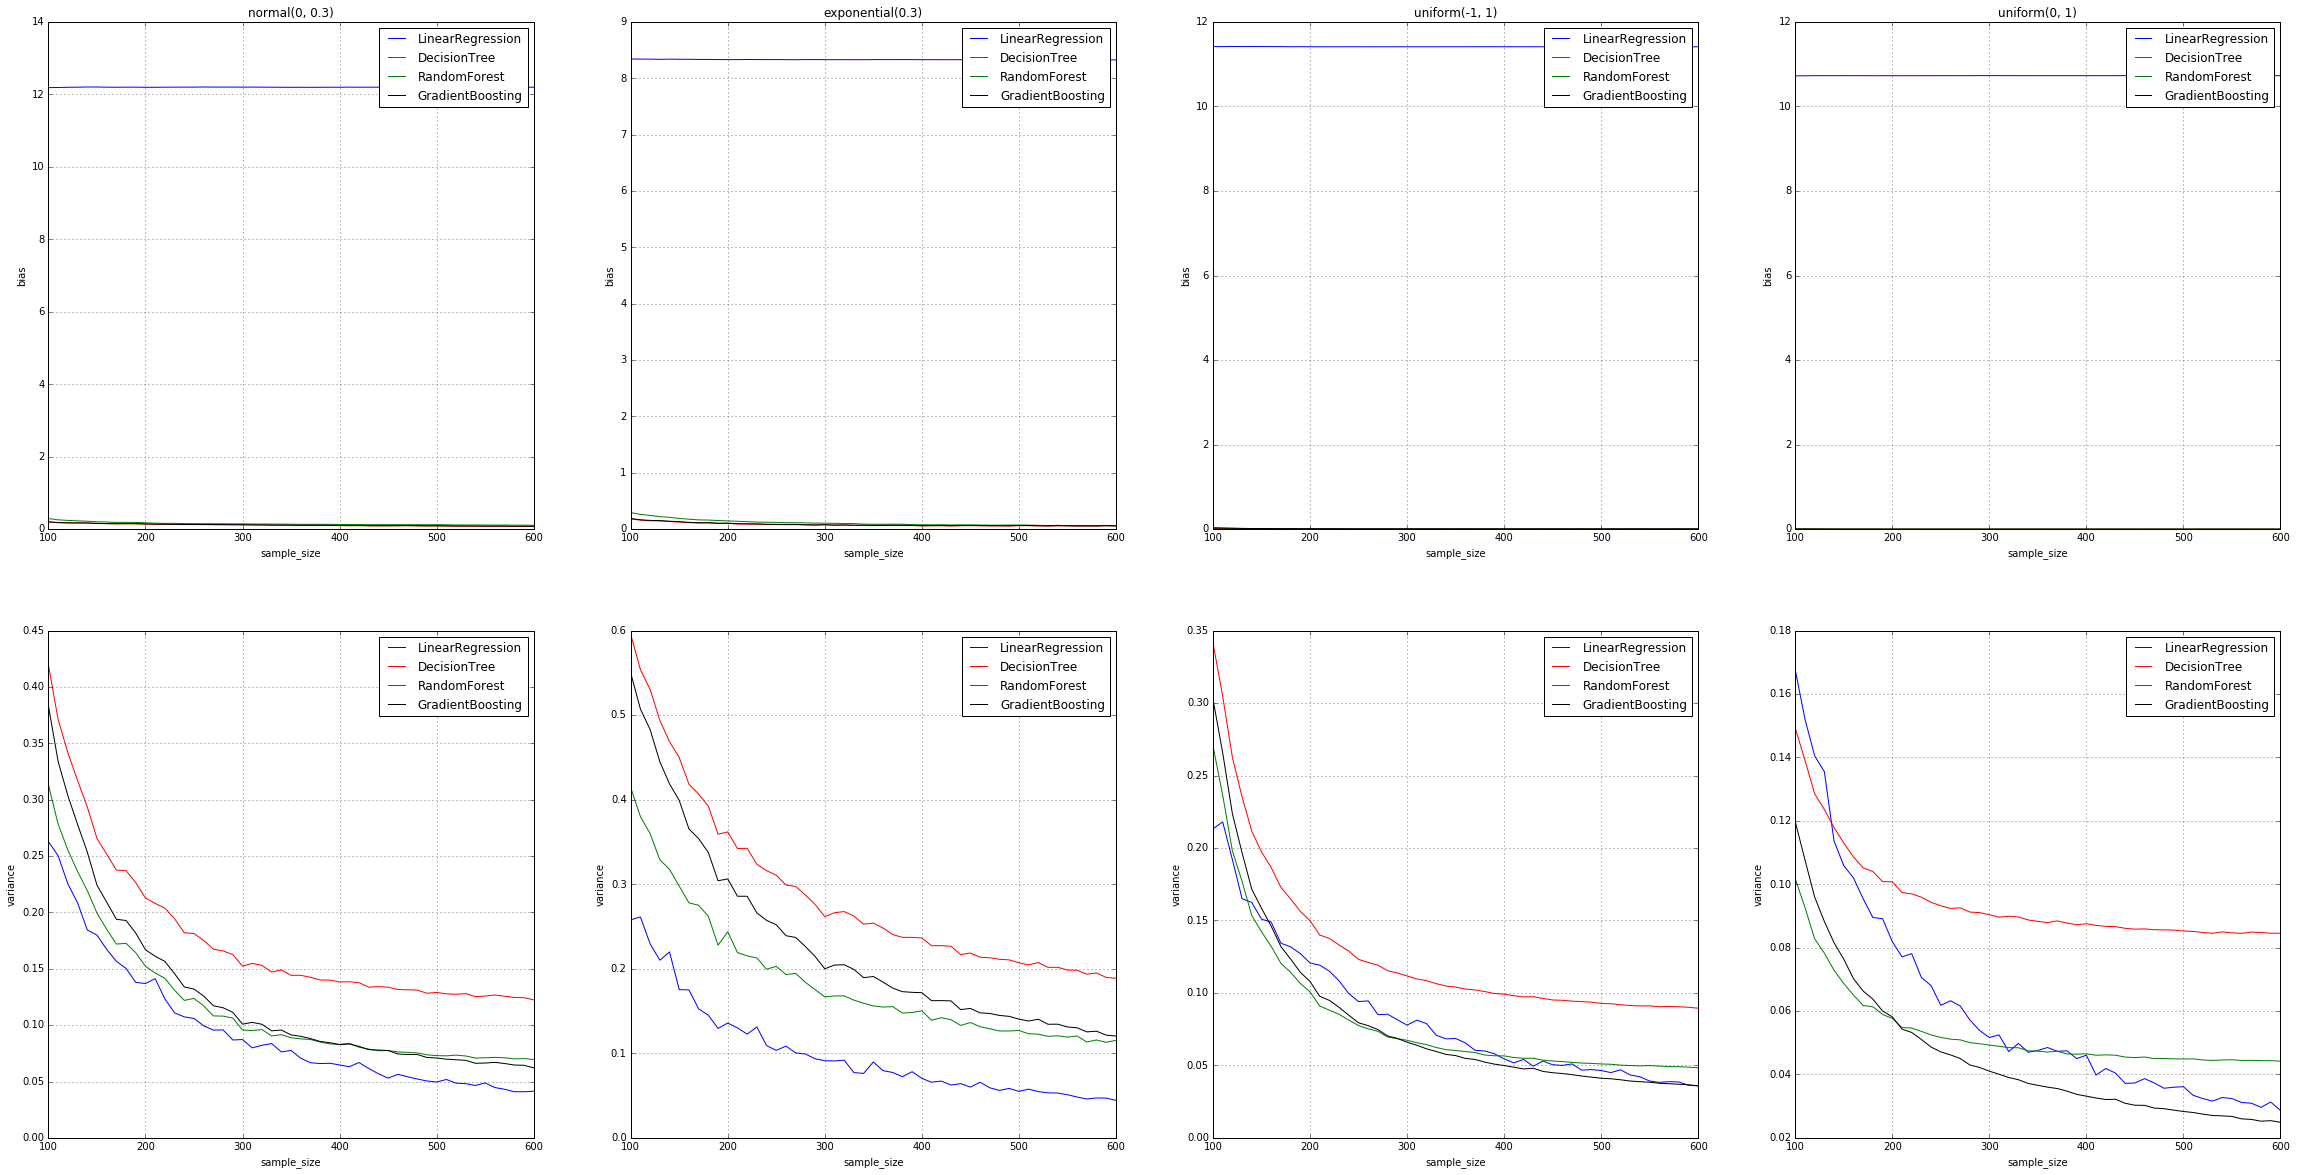

In [118]:
draw_bias_var('sample_size', [i for i in range(100, 610, 10)], 'Bias and variance of sample_size')

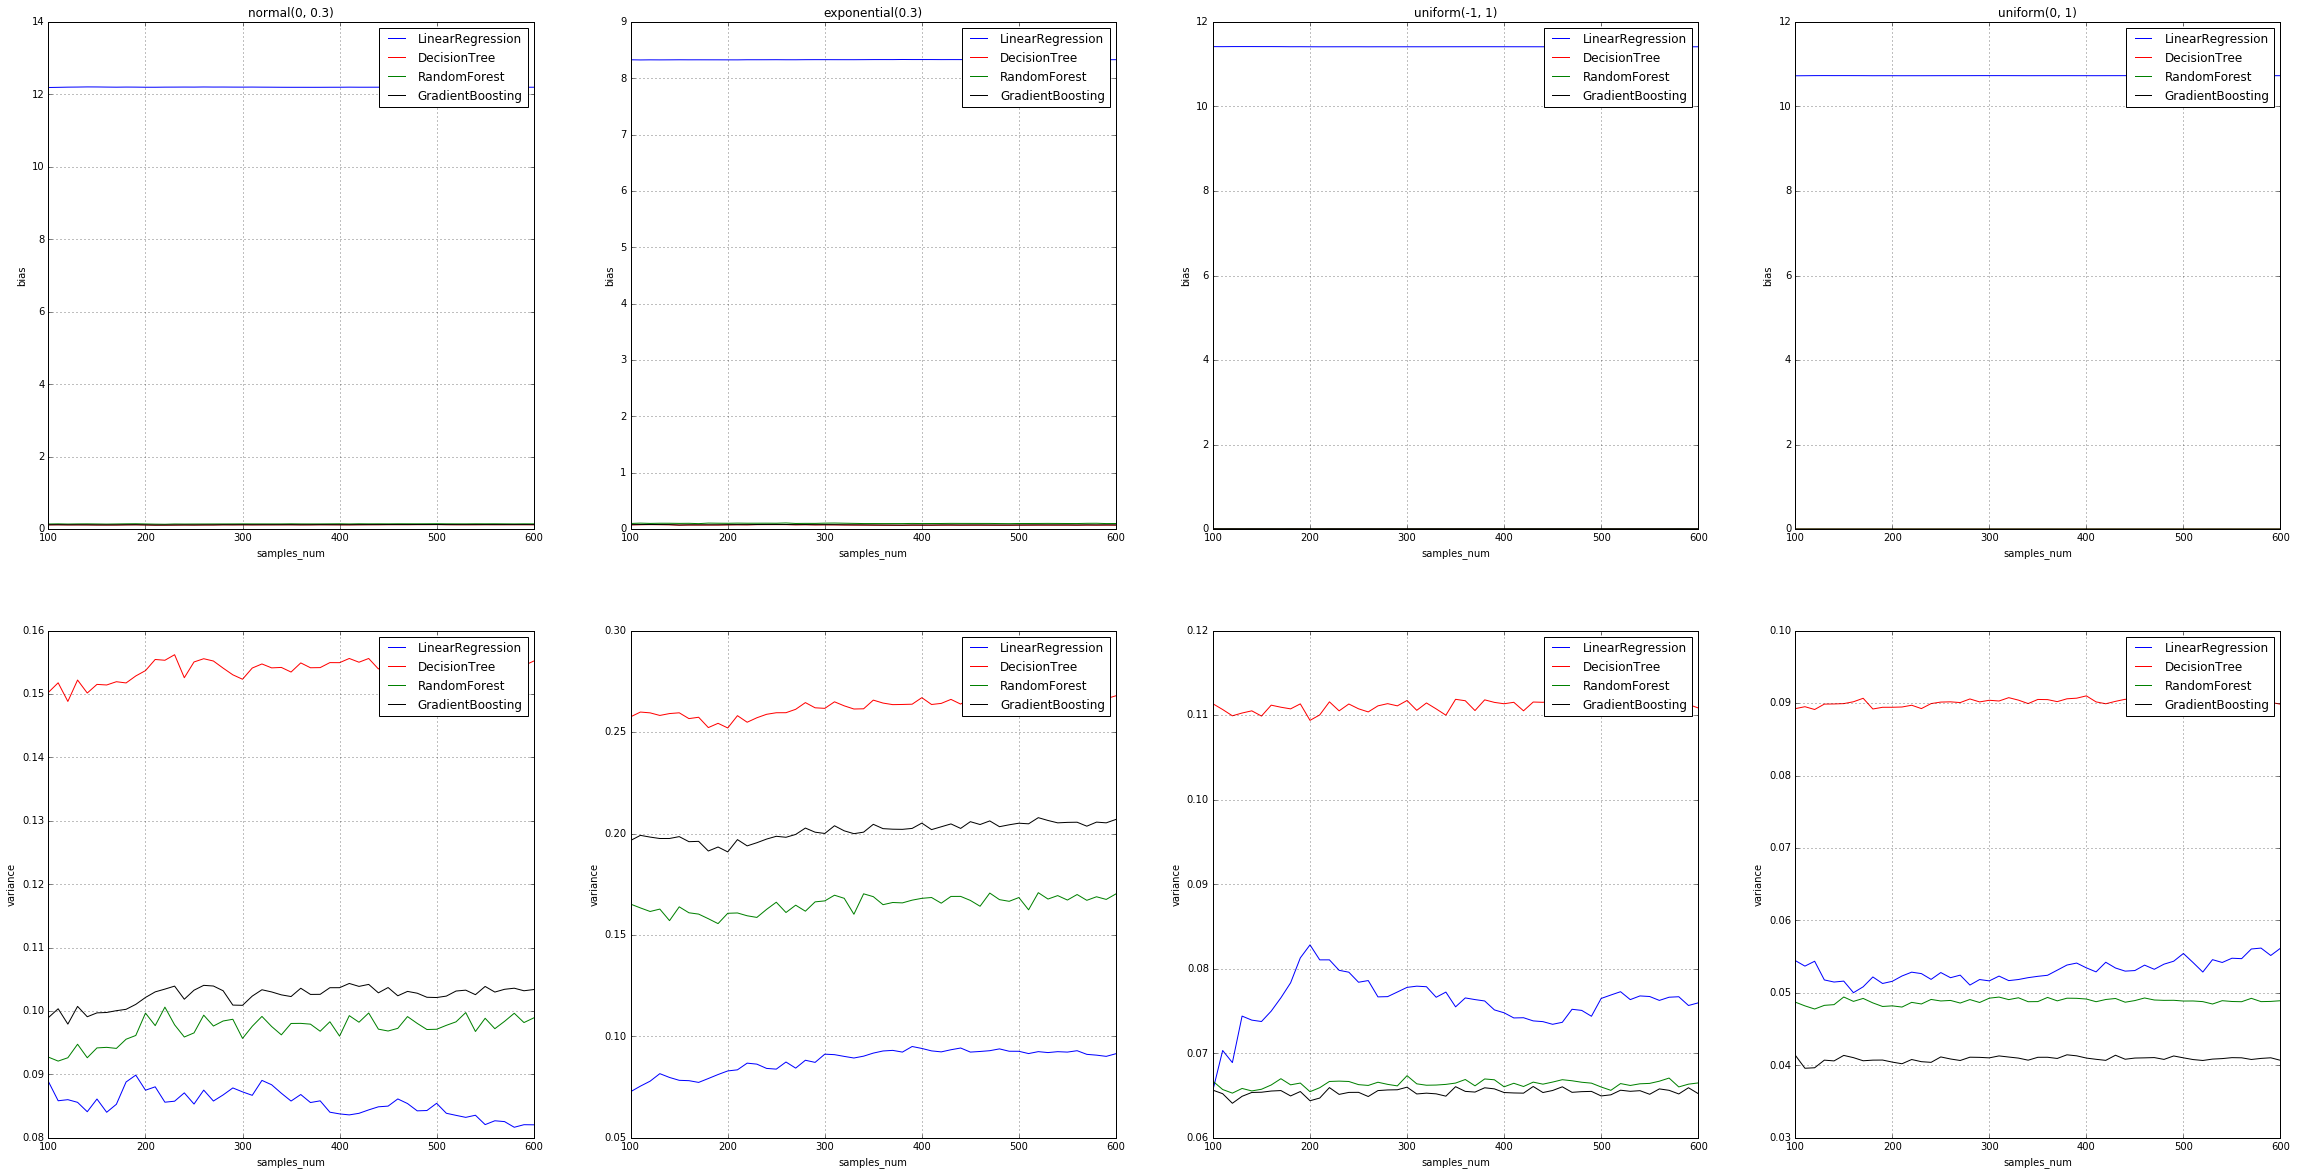

In [119]:
draw_bias_var('samples_num', [i for i in range(100, 610, 10)], 'Bias and variance of samples_num')

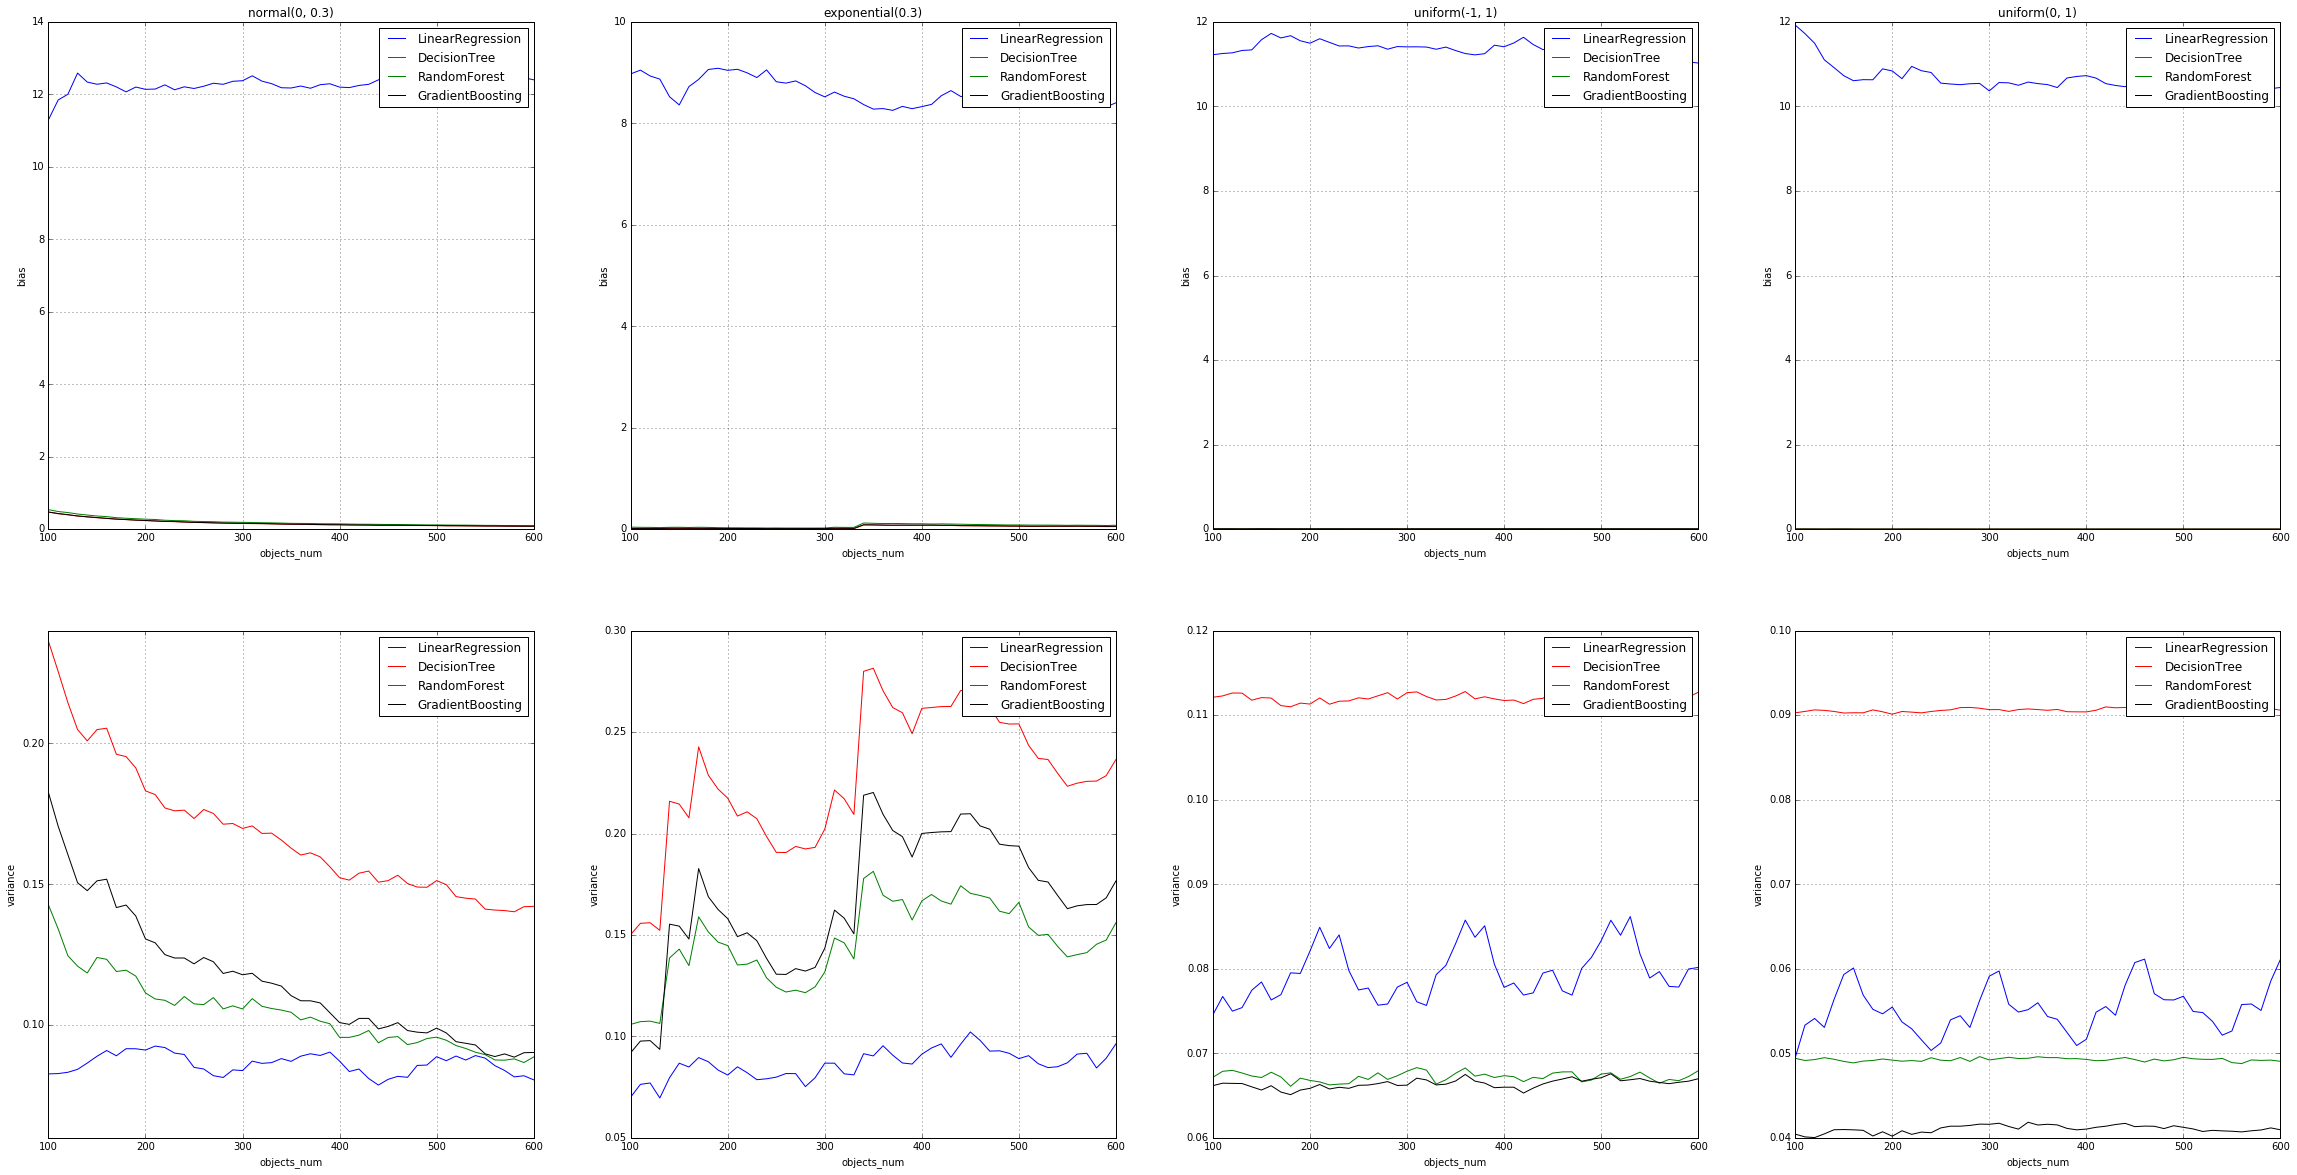

In [120]:
draw_bias_var('objects_num', [i for i in range(100, 610, 10)], 'Bias and variance of objects_num')

Ответ:

По данным графикам, параметры samples_num и objects_num не влияют на смещение или разброс, но влияют на точность их вычисления, что полностью согласуется с теорией. На некоторых графиках samples_size наблюдается изменение разброса на некоторых графиках, в принципе это согласуется с теорией.

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$,$R$— множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.



In [1076]:
reload(hw3code)

<module 'hw3code' from '/home/darya/Documents/MO/homework-practice-03-KorepanovaDarya/hw3code.py'>

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [1087]:
reload(hw3code)
students_data = pd.read_csv('students.csv')
target = students_data[' UNS']
students_data = students_data.drop(' UNS', axis=1)

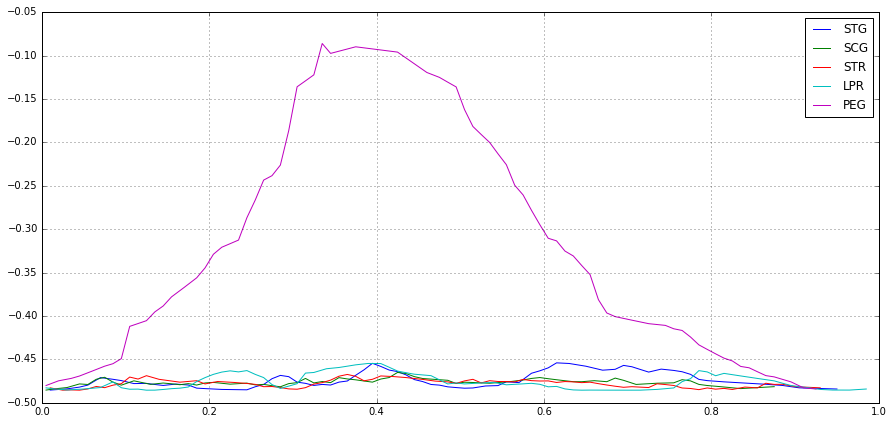

In [1088]:
plt.figure(figsize=(15, 7))
for feature in students_data.columns:
    thresholds, ginis, best_thr, best_gini = hw3code.find_best_split(students_data[feature].as_matrix(), target.as_matrix())
    plt.plot(thresholds, ginis, label=feature)
plt.legend()
plt.grid()
plt.show()

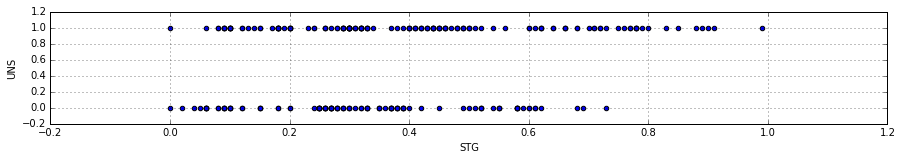

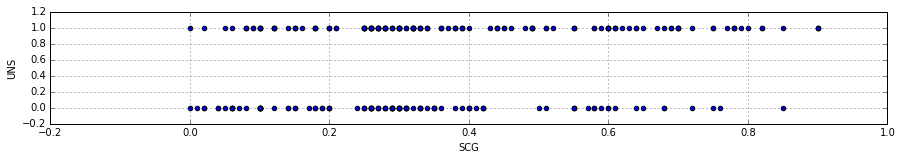

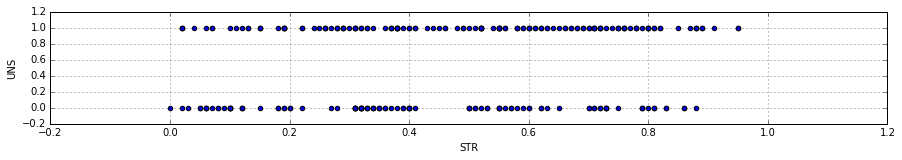

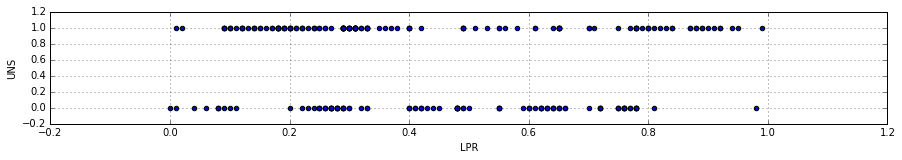

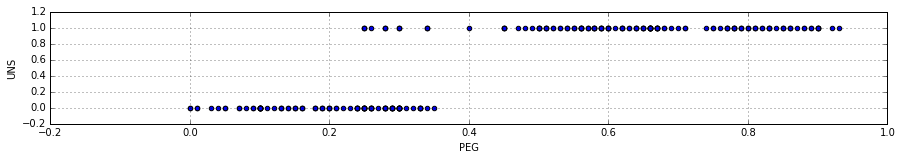

In [1089]:
for feature in students_data.columns:
    plt.figure(figsize=(15, 2))
    plt.scatter(students_data[feature], target)
    plt.xlabel(feature)
    plt.ylabel('UNS')
    plt.grid()
plt.show()

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
По графику можно заметить, что наилучшее значение функционала достигается при делении по признаку PEG, так как судя по plot.scatter, видно что выборку можно разбить таким образом, чтобы все объекты каждой части были практически из одного класса. Так как критерий Джини принимает минимальное значение на вырожденных классах, как в теории. Остальные признаки так хорошо не делятся.

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [1090]:
import hw3code
reload(hw3code)

<module 'hw3code' from '/home/darya/Documents/MO/homework-practice-03-KorepanovaDarya/hw3code.py'>

In [1124]:
from sklearn.preprocessing import LabelEncoder

mushrooms_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header=None)

le = LabelEncoder()
mushrooms_data = np.array(mushrooms_data)
             
for i in range(mushrooms_data.shape[1]):
    mushrooms_data[:, i] = le.fit_transform(mushrooms_data[:, i])

X_train, X_test, y_train, y_test = train_test_split(mushrooms_data[:, 1:], mushrooms_data[:, 0], train_size=0.5)
dt = hw3code.DecisionTree(feature_types=["categorical" for i in range(mushrooms_data.shape[1])], max_depth=4, min_samples_split=2, min_samples_leaf=1)
dt.fit(X_train, y_train)
prediction = dt.predict(X_test)
accuracy = accuracy_score(y_test[:].astype(np.int64), prediction)
print('\nAccuracy: {}\n'.format(accuracy))


Accuracy: 0.9967996061053668



/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [1125]:
tic_tac_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
                          header=None)
tic_tac_toe.head()

0  1  2  3  4  5  6  7  8         9
0  x  x  x  x  o  o  x  o  o  positive
1  x  x  x  x  o  o  o  x  o  positive
2  x  x  x  x  o  o  o  o  x  positive
3  x  x  x  x  o  o  o  b  b  positive
4  x  x  x  x  o  o  b  o  b  positive

In [1093]:
labeled_tic_tac_toe = np.apply_along_axis(LabelEncoder().fit_transform, 0, tic_tac_toe.as_matrix())
X_train, X_test, y_train, y_test = train_test_split(labeled_tic_tac_toe[:,:-1],
                                                    labeled_tic_tac_toe[:,-1], test_size=0.5)

In [1094]:
def draw_param_test(param_name, params):   
    plt.figure(figsize=(15, 5))
    plt.xlabel(param_name, size=15)
    plt.ylabel('accuracy', size=15)
    plt.grid()
    
    train_accuracy = []
    test_accuracy = []
    for param in params:
        decision_tree = hw3code.DecisionTree(np.array(['categorical' for x in range(X_train.shape[1])]),
                                             **{param_name:param})
        decision_tree.fit(X_train, y_train)
        train_accuracy.append(accuracy_score(y_train, decision_tree.predict(X_train)))
        test_accuracy.append(accuracy_score(y_test, decision_tree.predict(X_test)))
    
    plt.plot(params, train_accuracy, label='train')
    plt.plot(params, test_accuracy, label='test')
    plt.axis([min(params), max(params), min(min(train_accuracy), min(test_accuracy)), 1.1])
    plt.legend()
    plt.show()

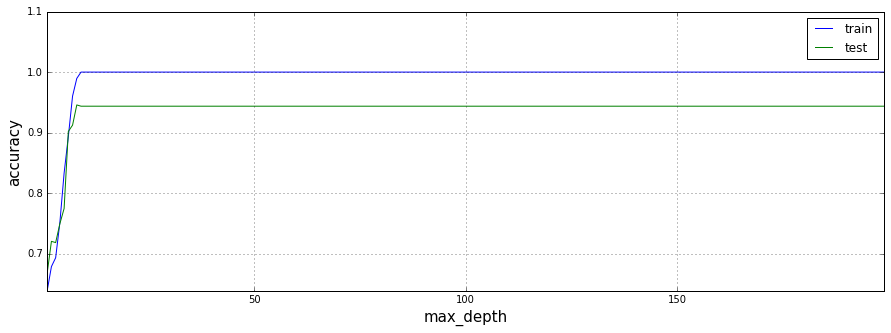

In [1095]:
max_depths = np.arange(1, 200)
draw_param_test('max_depth', max_depths)

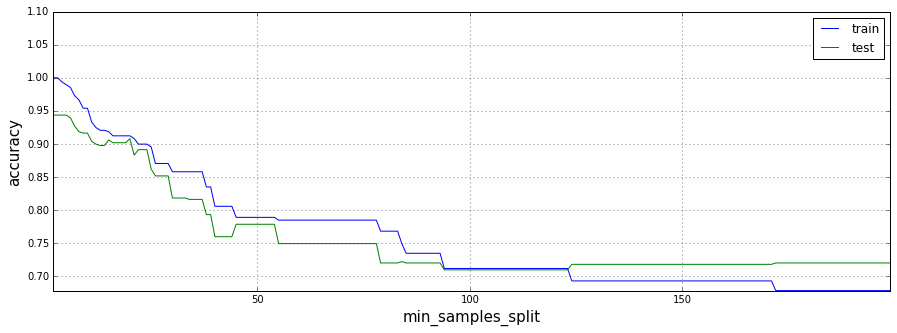

In [1096]:
min_samples_split = np.arange(2, 200)
draw_param_test('min_samples_split', min_samples_split)

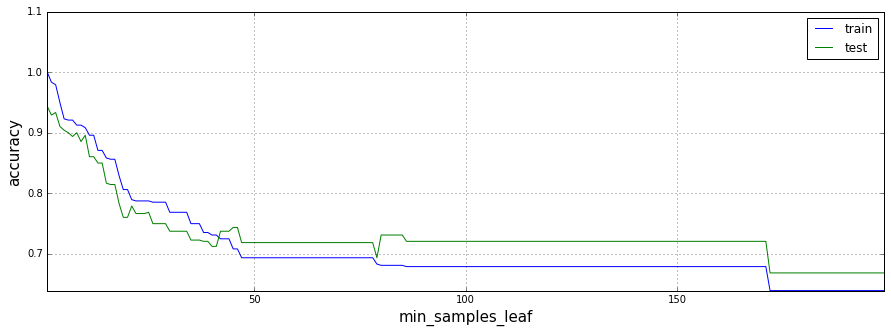

In [1097]:
min_samples_leaf = np.arange(1, 200)
draw_param_test('min_samples_leaf', min_samples_leaf)

Вывод:
Похоже, что переобучения нет, потому что по графикам видно, что результаты для теста и тренировочной выборки похожи. При увеличении глубины дерева точность увеличивается и переходит в ассимптоту. Возможно выборка неделима или плохо разделима. 

При увеличении мин числа объектов для деления и объектов в терминальной вершине точность начинает падать, это соответсвует теории.

__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [1123]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [1127]:
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)
cars.loc[:,6].replace({'unacc':0, 'acc':0, 'good':1, 'vgood':1}, inplace=True)
nursery.loc[:,8].replace({'not_recom':0, 'recommend':0, 'very_recom':1, 'priority':1, 'spec_prior':1}, inplace=True)
le = LabelEncoder()
cars = np.array(cars)
for i in range(cars.shape[1]):
    cars[:, i] = le.fit_transform(cars[:, i])
nursery = np.array(nursery)
for i in range(nursery.shape[1]):
    nursery[:, i] = le.fit_transform(nursery[:, i])

In [1126]:
alg = pd.DataFrame(index=['real features', 'categorical features', 'Real features + OneHot', 'DecisionTreeClassifier'],
                        columns=['mushrooms', 'tic-tac-toe', 'cars', 'nursery'])

In [1128]:
reload(hw3code)

<module 'hw3code' from '/home/darya/Documents/MO/homework-practice-03-KorepanovaDarya/hw3code.py'>

In [1129]:
def accuracy_tree(data, target, name):
    X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.5)
    dt = hw3code.DecisionTree(feature_types=['categorical' for i in range(data.shape[1])], max_depth=4, min_samples_split=2, min_samples_leaf=1)
    dt.fit(X_train, y_train)
    prediction = dt.predict(X_test)
    accuracy = accuracy_score(y_test[:].astype(np.int64), prediction)
    alg.loc['categorical features', name] = accuracy
    
    dt = hw3code.DecisionTree(feature_types=["real" for i in range(data.shape[1])], max_depth=4, min_samples_split=2, min_samples_leaf=1)
    dt.fit(X_train, y_train)
    prediction = dt.predict(X_test)
    accuracy = accuracy_score(y_test[:].astype(np.int64), prediction)
    alg.loc['real features', name] = accuracy
    dtclf = DecisionTreeClassifier()
    y_train = np.asarray(y_train, dtype='int')
    dtclf.fit(X_train, y_train)
    alg.loc['DecisionTreeClassifier', name] = accuracy_score(y_test[:].astype(np.int64), dtclf.predict(X_test))

    enc = OneHotEncoder(sparse=False)
    X_train = enc.fit_transform(X_train)
    X_test = enc.fit_transform(X_test)
    dt = hw3code.DecisionTree(feature_types=["real" for i in range(X_train.shape[1])], max_depth=4, min_samples_split=2, min_samples_leaf=1)
    dt.fit(X_train, y_train)
    prediction = dt.predict(X_test)
    accuracy = accuracy_score(y_test[:].astype(np.int64), prediction)
    alg.loc['Real features + OneHot', name] = accuracy

In [1130]:
accuracy_tree(cars[:, :-1], cars[:, -1], 'cars')
accuracy_tree(nursery[:, :-1], nursery[:, -1], 'nursery')
accuracy_tree(mushrooms_data[:, 1:], mushrooms_data[:, 0], 'mushrooms')
labeled_tic_tac_toe = np.apply_along_axis(LabelEncoder().fit_transform, 0, tic_tac_toe.as_matrix())
accuracy_tree(labeled_tic_tac_toe[:,:-1], labeled_tic_tac_toe[:,-1], 'tic-tac-toe')

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1131]:
print(alg)

                       mushrooms tic-tac-toe      cars   nursery
real features           0.960857    0.682672  0.916667  0.999846
categorical features    0.998031    0.732777  0.928241  0.999846
Real features + OneHot  0.989414    0.732777  0.930556  0.999846
DecisionTreeClassifier         1    0.843424  0.982639  0.999383


__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**результаты для mushrooms и nursery особо не отличаются.
Для tic-tac-toe результат на категориальных признаках лучше, чем на вещественных, наверное, это из-за случайного кодирования. OneHot на датасете tic-tac-toe показал так же, как "категориальный" способ, но хуже на датасете cars. OneHot сильно увеличивает количество признаков, тем самым усложняя структуру дерева, что может вести к переобучению. DecisionTreeClassifier везде показывает высокие результаты, что в принципе соответствует теории, так как решающие деревья легко переобучаются. Компонента случайности присутствует, если мы считаем все признаки действительными без OHE, т.к. задаётся случайный порядок на признаках. Похоже, что для улучшения алгоритма надо обосновать порядок для вещественных признаков, как например в DecisionTree для категориальных признаков.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [268]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

In [1069]:
import pandas as pd

data = pd.read_csv("train.csv")[:10000]
target = data.target

In [1070]:
data = data.select_dtypes(include=['float64'])
data = data.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.7, random_state=241)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [356]:
dtclf = DecisionTreeClassifier()
bclf = BaggingClassifier(n_estimators=100)
rfclf = RandomForestClassifier(n_estimators=100)

acc_dt = cross_val_score(dtclf, X_train, y_train, cv=3, scoring=make_scorer(accuracy_score))
acc_b = cross_val_score(bclf, X_train, y_train, cv=3, scoring=make_scorer(accuracy_score))
acc_rf = cross_val_score(rfclf, X_train, y_train, cv=3, scoring=make_scorer(accuracy_score))

In [357]:
print('\nAccuracy of Dacision Tree Classifier: {}\n'.format(acc_dt))
print('\nAccuracy of Bagging Classifier: {}\n'.format(acc_b))
print('\nAccuracy of Random Forest Classifier: {}\n'.format(acc_rf))


Accuracy of Dacision Tree Classifier: [ 0.66195373  0.66195373  0.66466552]


Accuracy of Bagging Classifier: [ 0.74635818  0.75235647  0.75343053]


Accuracy of Random Forest Classifier: [ 0.75578406  0.75407027  0.75686106]



#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [358]:
rfclf = RandomForestClassifier(warm_start=True)
accuracy_train = []
accuracy_test = []
linspace = []
for i in range(20,5000, 20):
    rfclf.set_params(n_estimators=i)
    rfclf.fit(X_train, y_train)
    acc_te = rfclf.score(X_test, y_test)
    acc_tr = rfclf.score(X_train, y_train)
    accuracy_train.append(acc_tr)
    accuracy_test.append(acc_te)
    linspace.append(i)

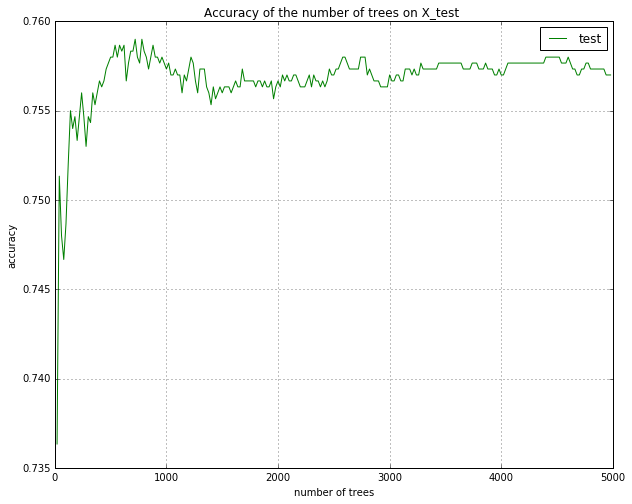

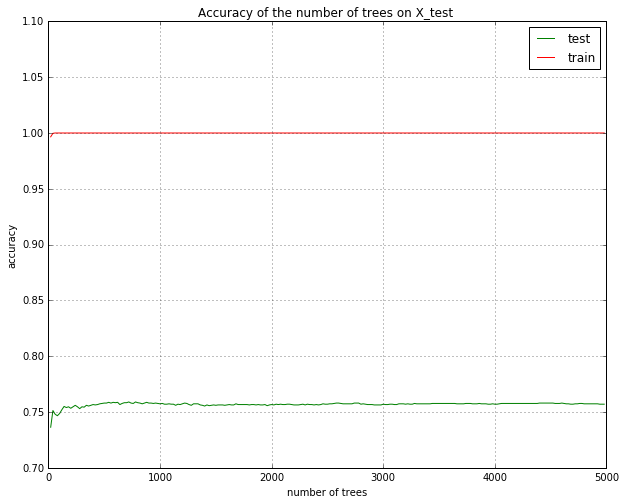

In [359]:
linspace = [i for i in range(20, 5000, 20)]
plt.figure(figsize=(10, 8))
plt.plot(linspace, accuracy_test, label='test', color='green')
#plt.plot(linspace, accuracy_train, label='train', color='red')
plt.title('Accuracy of the number of trees on X_test ')
plt.ylabel('accuracy')
plt.xlabel('number of trees')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(linspace, accuracy_test, label='test', color='green')
plt.plot(linspace, accuracy_train, label='train', color='red')
plt.title('Accuracy of the number of trees on X_test ')
plt.ylabel('accuracy')
plt.xlabel('number of trees')
plt.legend()
plt.axis([0, 5000, 0.7, 1.1])
plt.grid()
plt.show()

Начиная с определенного числа деревьев, accuracy на тесте становится константой, то есть можно выбрать оптимальное количество деревьев, но при этом на тренировочной выборке accuracy = 1, начиная с какого-то момента, что говорит о 100% точности, а это переобучение.

#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__


А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [1065]:
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, roc_auc_score

#параметры по умолчанию
clf = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, 
                    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                    nthread=4, scale_pos_weight=1, seed=27)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



Accuracy: 0.7376666666666667


AUC-ROC(test): 0.5597686740451986


AUC-ROC(train): 0.9938041810825766



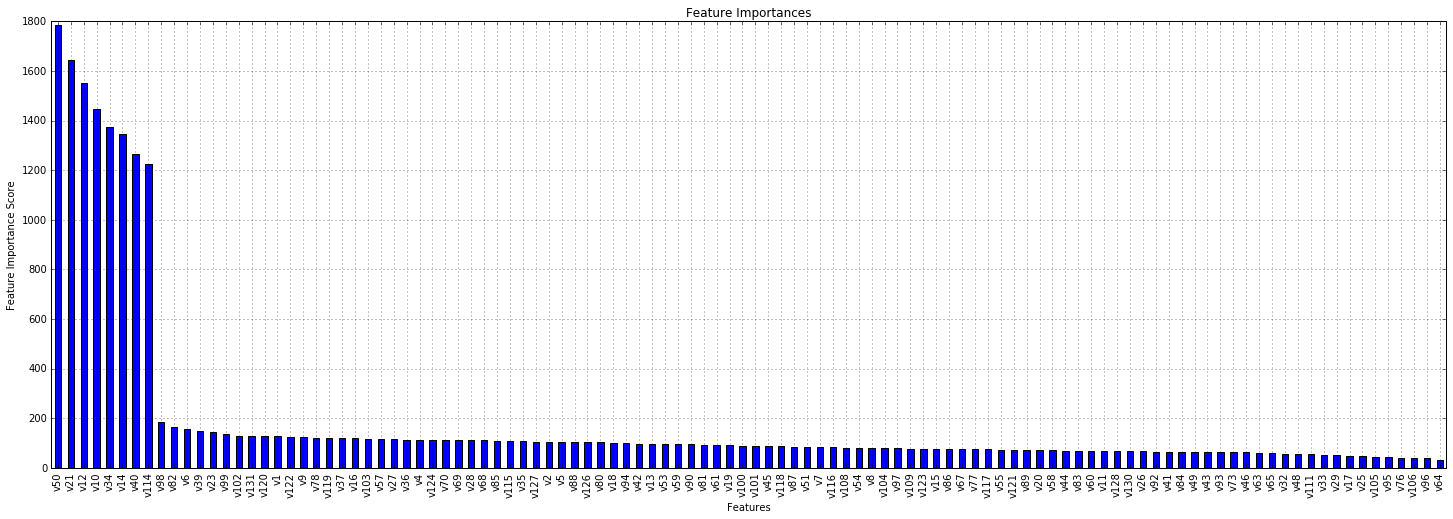

In [79]:
accuracy_test = accuracy_score(y_test, prediction)
auc_roc_test = roc_auc_score(y_test, prediction)
auc_roc_train = roc_auc_score(y_train, clf.predict(X_train))

print('\nAccuracy: {}\n'.format(accuracy))
print('\nAUC-ROC(test): {}\n'.format(auc_roc_test))
print('\nAUC-ROC(train): {}\n'.format(auc_roc_train))


plt.figure(figsize=(25, 8))
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.grid()
plt.show()
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку.

(・・ ) ?